In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [4]:
dados = pd.read_csv('./MICRODADOS_ENEM_2022.csv', sep=';', encoding='ISO-8859-1')
dados.dropna(inplace=True)
dados.reset_index(drop=True, inplace=True)

In [5]:
target = dados.NU_NOTA_MT
nota_humanas = dados.NU_NOTA_CH
sexo = dados.TP_SEXO
cor_raca = dados.TP_COR_RACA
renda = dados.Q006
treineiro = dados.IN_TREINEIRO

In [23]:
sexo = pd.Categorical(sexo)
cor_raca = pd.Categorical(cor_raca)
renda = pd.Categorical(renda)
treineiro = pd.Categorical(treineiro)

cor_raca = cor_raca.rename_categories(['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'])
renda = renda.rename_categories([
    'Nenhuma Renda', 
    'Até R$ 1.212,00', 
    'De R$ 1.212,01 até R$ 1.818,00',
    'De R$ 1.818,01 até R$ 2.424,00',
    'De R$ 2.424,01 até R$ 3.030,00',
    'De R$ 3.030,01 até R$ 3.636,00',
    'De R$ 3.636,01 até R$ 4.848,00',
    'De R$ 4.848,01 até R$ 6.060,00',
    'De R$ 6.060,01 até R$ 7.272,00',
    'De R$ 7.272,01 até R$ 8.484,00',
    'De R$ 8.484,01 até R$ 9.696,00',
    'De R$ 9.696,01 até R$ 10.908,00',
    'De R$ 10.908,01 até R$ 12.120,00',
    'De R$ 12.120,01 até R$ 14.544,00',
    'De R$ 14.544,01 até R$ 18.180,00',
    'De R$ 18.180,01 até R$ 24.240,00',
    'Acima de R$ 24.240,00'
])
treineiro = treineiro.rename_categories(['Não Treineiro', 'Treineiro'])

dados['TP_SEXO'] = sexo
dados['TP_COR_RACA'] = cor_raca
dados['Q006'] = renda
dados['IN_TREINEIRO'] = treineiro

### Comparando a variável target (Nota de matemática) com a feature (Sexo)

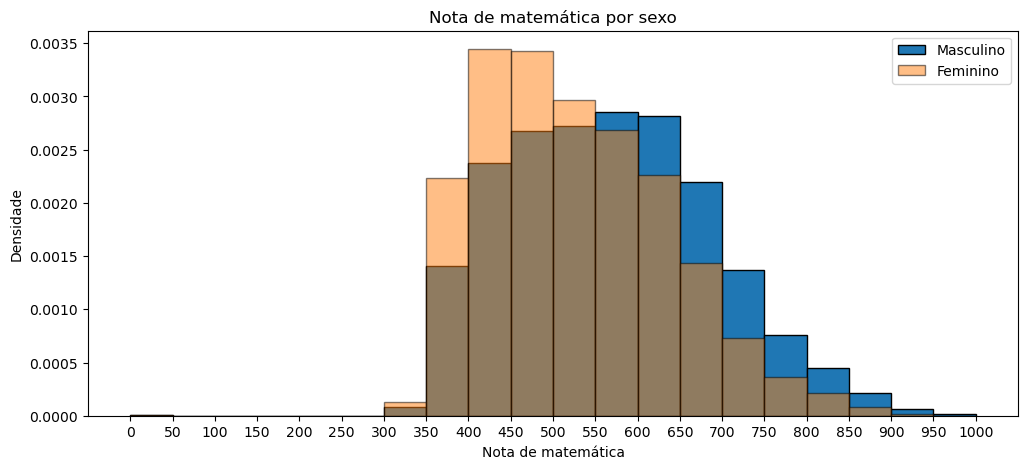

In [7]:
nota_mat_masc = dados.loc[dados.TP_SEXO == 'M', 'NU_NOTA_MT']
nota_mat_fem = dados.loc[dados.TP_SEXO == 'F', 'NU_NOTA_MT']

amp = np.linspace(0, 1000, 21)
plt.figure(figsize=(12, 5))
plt.hist(nota_mat_masc, bins=amp, edgecolor='black', density=True, label='Masculino')
plt.hist(nota_mat_fem, bins=amp, edgecolor='black', density=True, alpha=0.5, label='Feminino')
plt.title('Nota de matemática por sexo')
plt.ylabel('Densidade')
plt.xlabel('Nota de matemática')
plt.xticks(amp)
plt.legend()
plt.show()

In [8]:
dados.groupby('TP_SEXO').describe()['NU_NOTA_MT'].T.apply(lambda x: x.round(2))

TP_SEXO,F,M
count,1436668.00,908155.00
mean,526.70,567.78
std,109.86,120.79
min,0.00,0.00
25%,438.70,471.50
50%,512.20,563.00
75%,602.30,651.10
max,985.70,985.70


Ao observar o histograma e as estatísticas descritivas dos dados é possível perceber que tanto a média como a mediana da nota dos homens em matemática é maior do que a das mulheres, fato que provavelmente se deve à falta de incentivos para as mulheres nas áreas de ciências exatas. Isso sugere que políticas e práticas que promovam a igualdade de gênero nas áreas de STEM (ciência, tecnologia, engenharia e matemática) podem ser benéficas para reduzir essa discrepância.

Além disso, é possível perceber que as notas das mulheres são mais concentradas que as dos homens devido ao seu menor desvio padrão.

### Comparando a variável target (Nota de matemática) com a feature (Nota de humanas)

In [9]:
corr = target.corr(nota_humanas)
print(f'A correlação entre a nota de matemática (target) e a nota de ciências humanas (feature): {corr:.5f}')

A correlação entre a nota de matemática (target) e a nota de ciências humanas (feature): 0.62142


A correlação entre as notas de matemática e de ciências humanas é positiva e moderada, chegando relativamente perto de ser alta, indicando que pessoas que tiram notas maiores em ciências humanas têm uma tendência de ir bem também em matemática. A existência dessa correlação pode ser explicada por métodos de estudo eficazes que servem para o estudo de ambas as áreas, levando um aluno que vai bem em uma matéria a ir bem nas demais.

### Comparando a variável target (Nota de matemática) com a feature (Cor/Raça)

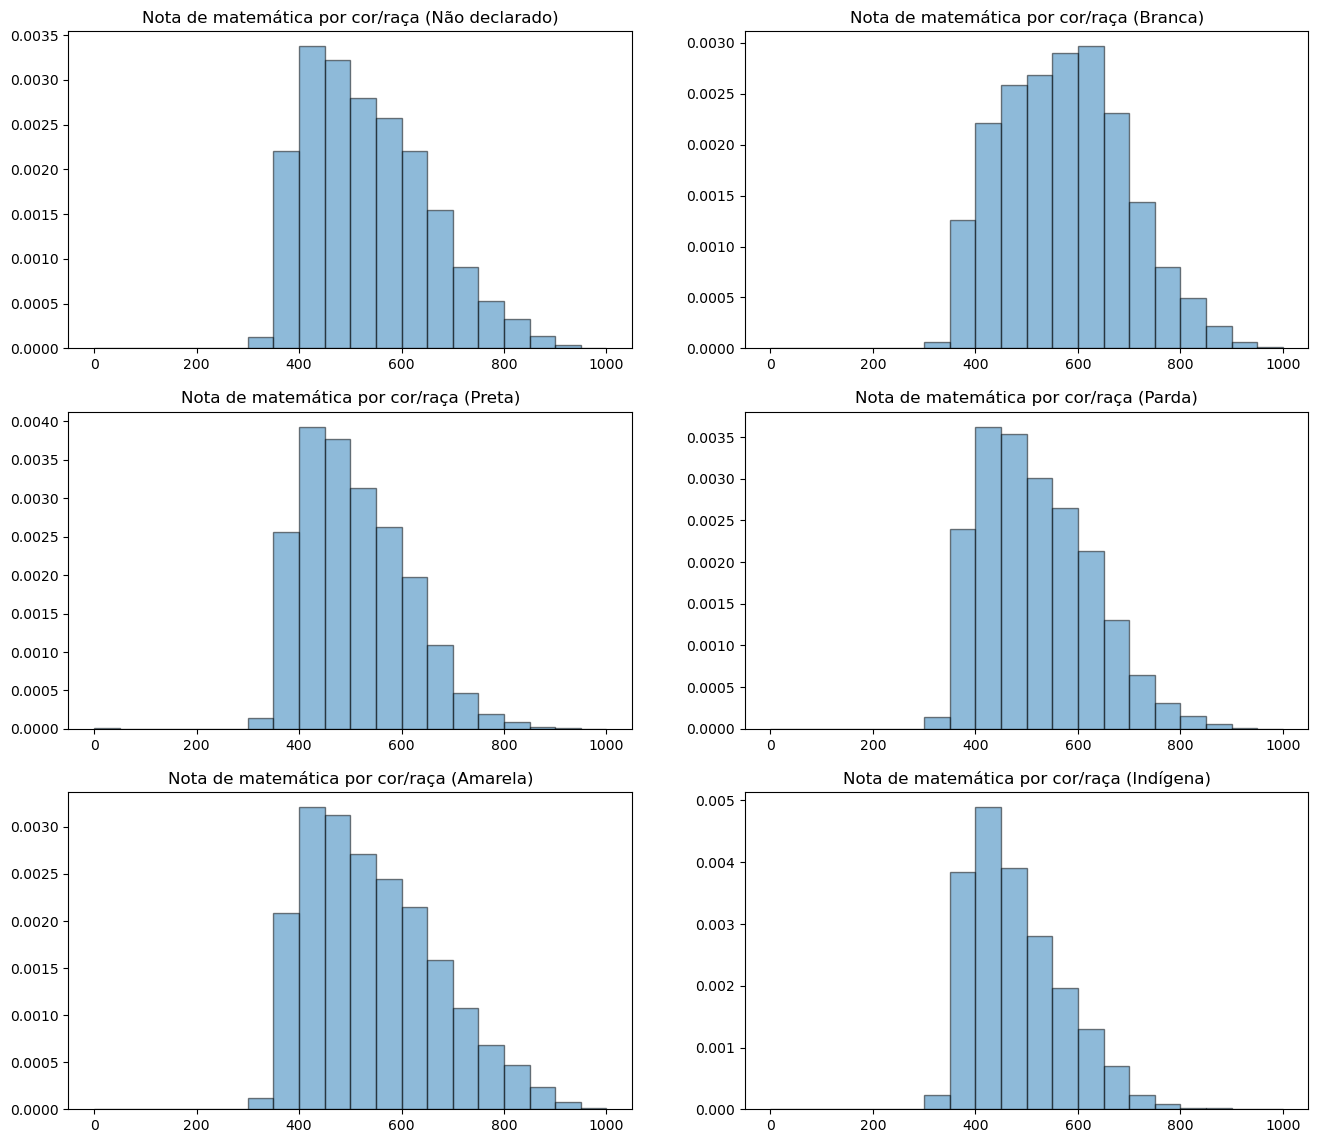

In [10]:
amp = np.linspace(0, 1000, 21)
plt.figure(figsize=(16, 14))
for category in cor_raca.categories:
    notas = dados.loc[dados.TP_COR_RACA == category, 'NU_NOTA_MT']
    plt.subplot(3, 2, cor_raca.categories.get_loc(category) + 1)
    plt.hist(notas, bins=amp, alpha=0.5, density=True, edgecolor='black')
    plt.title(f'Nota de matemática por cor/raça ({category})')
plt.show()

In [11]:
dados.groupby('TP_COR_RACA').describe()['NU_NOTA_MT'].T.apply(lambda x: x.round(2))

TP_COR_RACA,Não declarado,Branca,Preta,Parda,Amarela,Indígena
count,40871.00,1026418.00,255863.00,966698.00,43782.00,11191.00
mean,535.09,573.55,508.51,519.71,545.35,480.20
std,118.41,120.03,99.37,106.78,125.77,91.12
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,439.75,478.50,429.70,434.60,443.50,409.50
50%,518.30,571.20,494.10,504.60,525.90,461.70
75%,614.55,656.00,576.70,592.70,628.58,535.50
max,983.90,985.70,981.30,985.70,985.70,936.30


Ao observar o histograma e as estatísticas descritivas dos dados é possível perceber que os brancos foram os que obtieram a maior média e mediana, já os indígenas obtiveram a menor média e mediana, com os pretos tendo o segundo pior desempenho. Muito disso pode ser explicado devido a fatores socioeconômicos, por exemplo o acesso a educação precária que muitos jovens indígenas têm pode ser uma justificativa do porquê desses povos terem um desempenho abaixo dos demais. 

Além disso, os pretos terem desempenho médio inferior aos brancos é um forte indicativo do racismo estrutural presente no Brasil, com as grandes diferenças existentes entre as oportunidades dadas a cada uma das etnias, gerando essa grande discrepância no desempenho. Ainda mais, pode-se perceber que os dados dos não declarados tendem a se distinguir dos brancos e se aproximar das demais etnias.

Ainda é possível notar que os desvios padrões tendem a seguir a mesma ordem do desempenho, com o pior desempenho tendo o menor desvio padrão e assim por diante, podendo indicar que pessoas pertencentes {as etnias de pior desempenho tiveram oportunidades de estudo parecidas, enquanto brancos por exemplo tiveram diferentes níveis de oportunidade, possivelmente explicado por outros fatores, como a renda.  

### Comparando a variável target (Nota de matemática) com a feature (Treineiro)

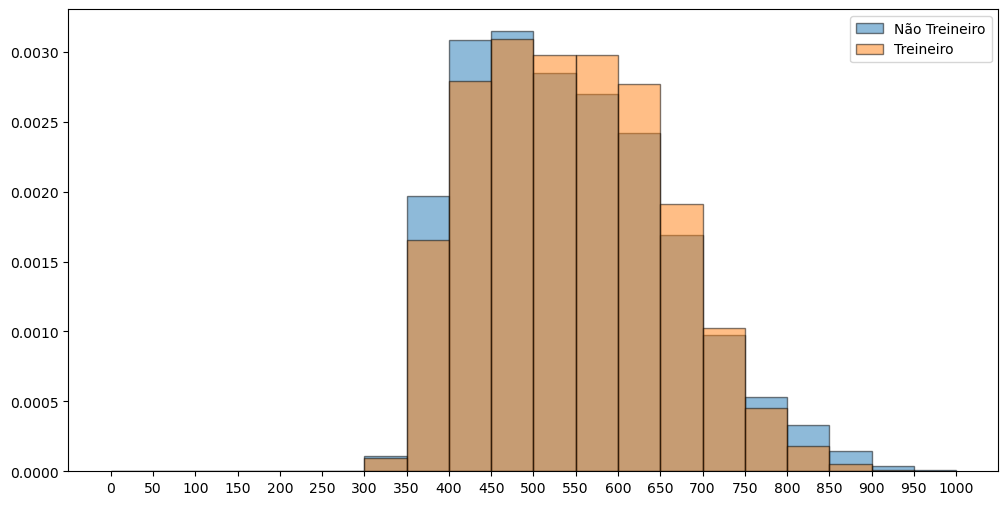

In [12]:
amp = np.linspace(0, 1000, 21)
plt.figure(figsize=(12, 6))
for category in treineiro.categories:
    notas = dados.loc[dados.IN_TREINEIRO == category, 'NU_NOTA_MT']
    plt.hist(notas, bins=amp, alpha=0.5, label=category, density=True, edgecolor='black')
    plt.legend()
    plt.xticks(amp)

plt.show()

In [13]:
dados.groupby('IN_TREINEIRO').describe()['NU_NOTA_MT'].T.apply(lambda x: x.round(2))

IN_TREINEIRO,Não Treineiro,Treineiro
count,1927753.00,417070.00
mean,542.09,545.03
std,117.41,108.98
min,0.00,0.00
25%,447.40,457.20
50%,529.00,539.30
75%,622.10,623.80
max,985.70,985.70


Ao observar o histograma e as estatísticas descritivas dos dados é possível perceber que os treineiros tiveram um desempenho um pouco melhor do que os não treineiros, mas não se trata de uma diferença tão significativa, olhando apenas para a média. Já quando se olha para a mediana é possível notar que os treineiros tiveram um desempenho simétrico enquanto os não treineiros tiveram um desempenho com assimetria à direita.

### Comparando a variável target (Nota de matemática) com a feature (Renda)

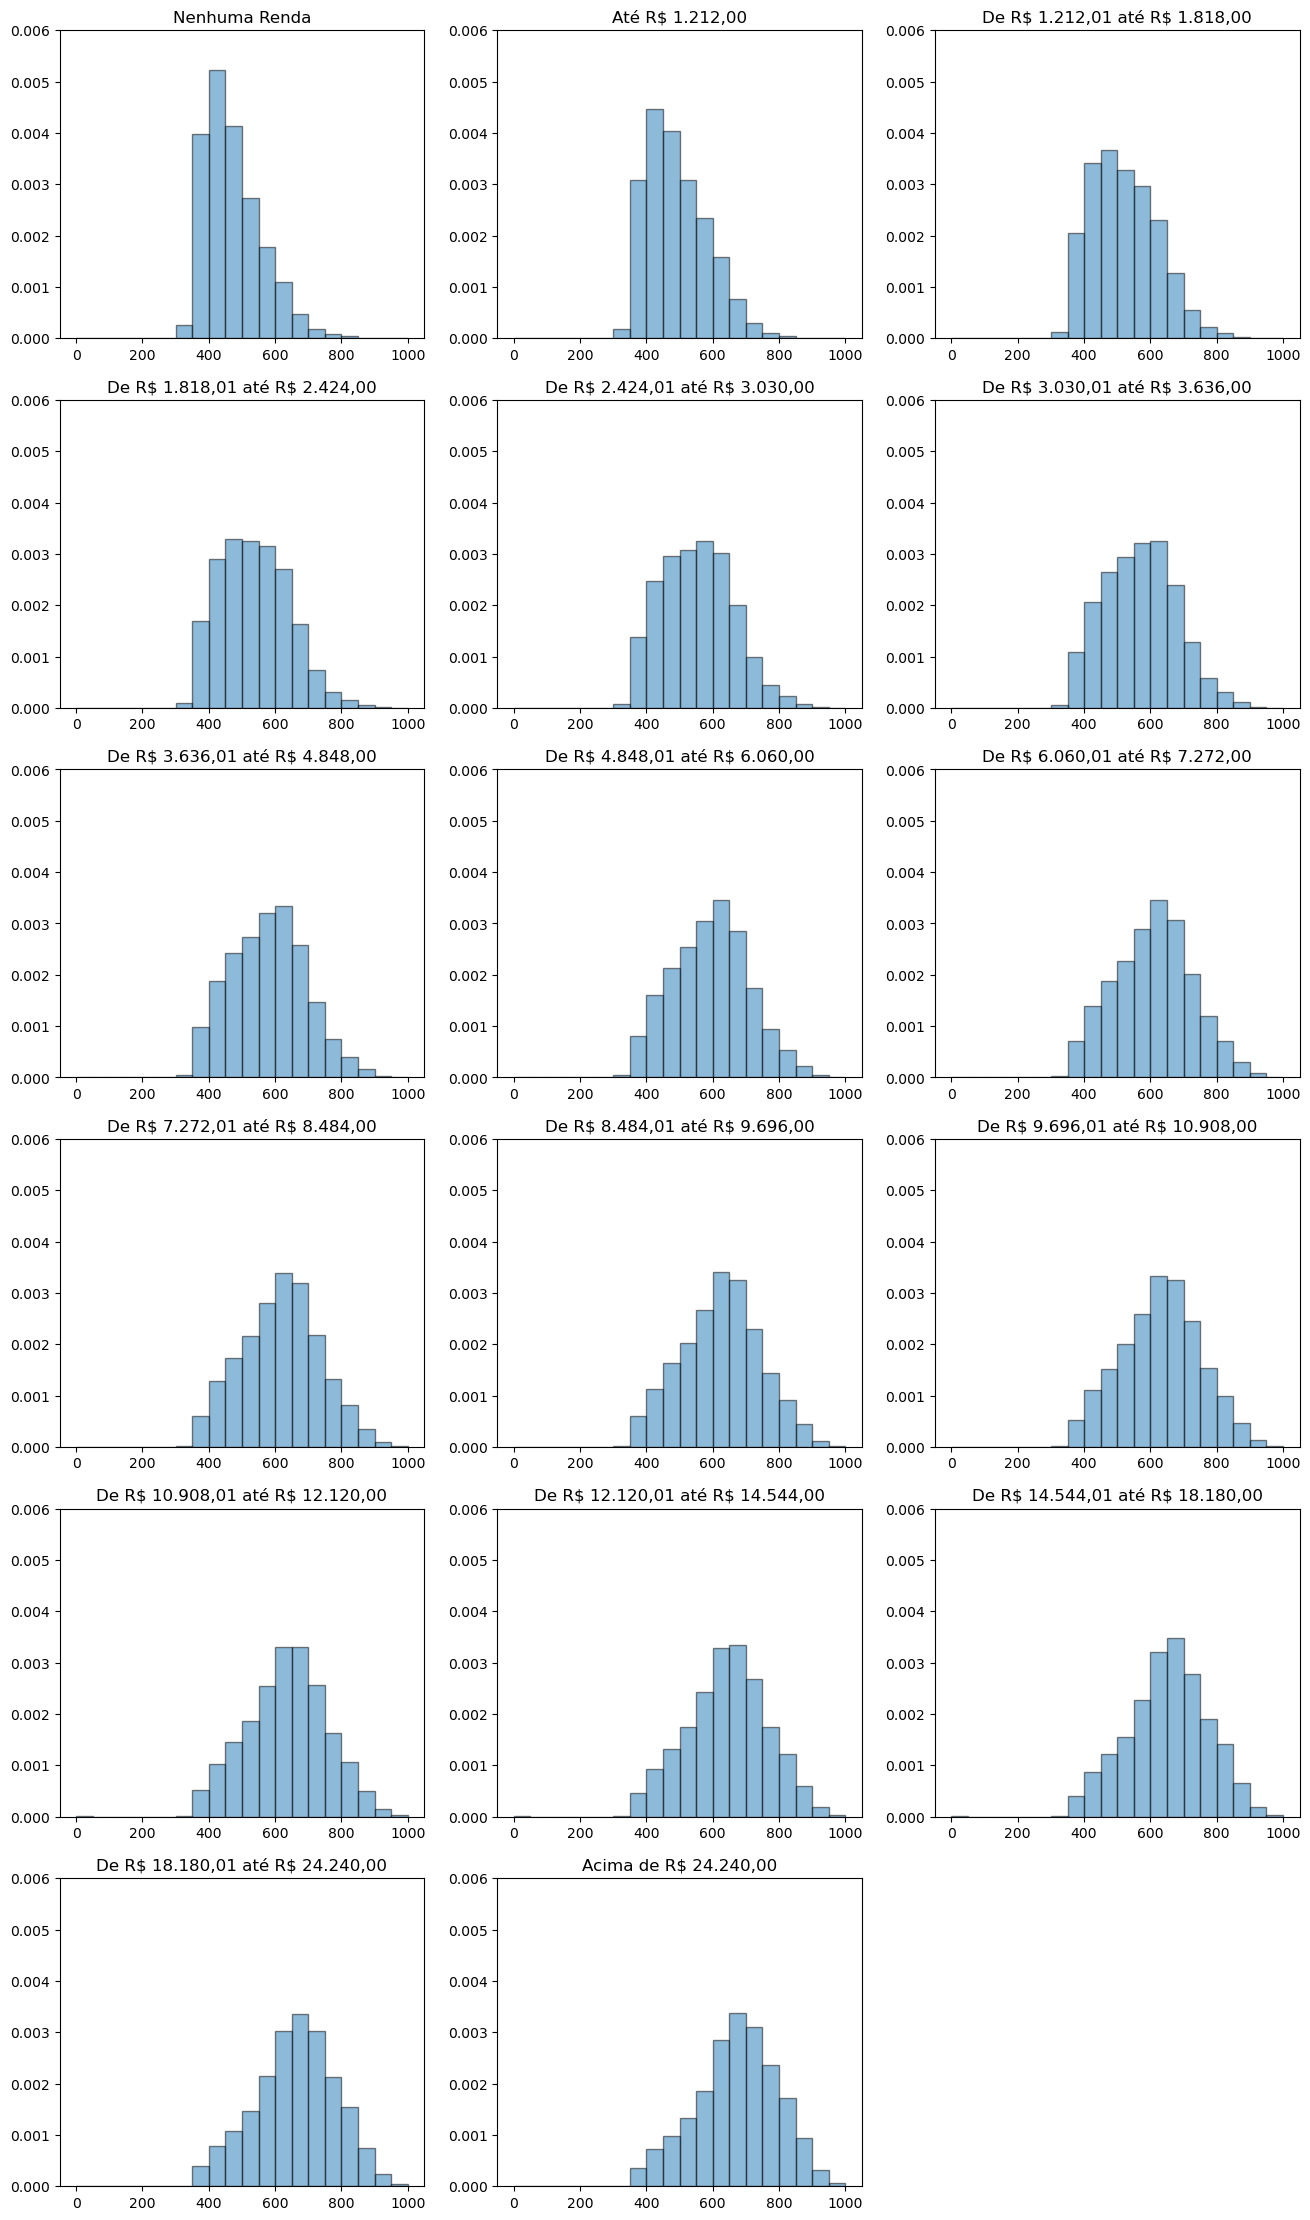

In [14]:
amp = np.linspace(0, 1000, 21)
plt.figure(figsize=(16, 28))
for category in renda.categories:
    notas = dados.loc[dados.Q006 == category, 'NU_NOTA_MT']
    plt.subplot(6, 3, renda.categories.get_loc(category) + 1)
    plt.hist(notas, bins=amp, alpha=0.5, density=True, edgecolor='black')
    plt.title(category.replace('$', '\$'))
    plt.ylim(0, 0.006)
plt.show()

In [15]:
dados.groupby('Q006').describe()['NU_NOTA_MT'].T.apply(lambda x: x.round(2))

Q006,Nenhuma Renda,"Até R$ 1.212,00","De R$ 1.212,01 até R$ 1.818,00","De R$ 1.818,01 até R$ 2.424,00","De R$ 2.424,01 até R$ 3.030,00","De R$ 3.030,01 até R$ 3.636,00","De R$ 3.636,01 até R$ 4.848,00","De R$ 4.848,01 até R$ 6.060,00","De R$ 6.060,01 até R$ 7.272,00","De R$ 7.272,01 até R$ 8.484,00","De R$ 8.484,01 até R$ 9.696,00","De R$ 9.696,01 até R$ 10.908,00","De R$ 10.908,01 até R$ 12.120,00","De R$ 12.120,01 até R$ 14.544,00","De R$ 14.544,01 até R$ 18.180,00","De R$ 18.180,01 até R$ 24.240,00","Acima de R$ 24.240,00"
count,119268.00,630492.00,369704.00,276804.00,194527.0,115203.00,145812.00,145866.00,62344.00,44115.00,31448.00,41407.00,39300.00,28365.00,31826.00,29282.00,39060.00
mean,472.89,492.06,520.95,537.09,553.2,569.26,579.26,593.96,608.17,616.69,623.73,628.40,634.18,642.84,650.65,659.34,670.56
std,86.41,92.54,100.00,103.93,107.8,110.29,112.53,114.82,117.70,118.21,119.71,119.98,120.60,121.12,121.22,121.73,124.05
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,407.20,419.70,441.90,454.80,468.5,484.60,493.68,508.62,523.10,533.25,539.60,545.10,552.70,563.00,572.82,581.80,593.60
50%,455.40,476.40,510.80,530.70,550.7,569.40,581.00,597.40,612.60,621.10,628.20,633.50,639.25,647.30,656.40,665.50,677.60
75%,523.20,552.60,590.90,610.10,628.4,645.70,656.60,671.80,687.40,696.60,704.30,709.90,715.90,725.10,732.80,743.70,757.50
max,951.90,977.00,983.20,985.70,975.0,985.70,985.70,985.70,981.30,977.00,983.90,979.70,983.90,985.70,985.70,985.70,983.90


A análise dos gráficos e a interpretação dos dados revelaram uma tendência interessante em relação às notas dos estudantes em função de sua faixa de renda. A métrica utilizada para representar o centro das notas foi a mediana, e ao analisá-la percebemos que a mediana das notas aumenta à medida que a faixa de renda cresce.

Uma possível explicação seria que famílias com maior poder aquisitivo têm acesso à melhores escolas, tutores particulares, materiais didáticos e outras coisas. Além disso, a estabilidade financeira pode reduzir as preocupações relacionadas a necessidades básicas, permitindo que os alunos se concentrem mais nos estudos (o que sabemos que não é a realidade da maioria dos adolescentes no Brasil que, por muitas vezes, precisam trabalhar enquanto estudam).

In [34]:
dados_quali = (dados.dtypes == 'category')
quali_cols = list(dados_quali[dados_quali].index)
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dados[quali_cols]))
OH_cols.index = dados.index
OH_cols.columns = OH_encoder.get_feature_names_out()
dados_final = dados.drop(quali_cols, axis=1)
dados_final = pd.concat([dados_final, OH_cols], axis=1)

c:\Users\ribei\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
features = dados_final.drop(['NU_NOTA_MT'], axis=1)
target = dados_final['NU_NOTA_MT']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=1234)

In [53]:
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predicao_LR = model_LR.predict(features_test)

In [56]:
mse = np.sqrt(mean_squared_error(target_test, predicao_LR))
mse

85.98363466422497

In [57]:
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(features_train, target_train)
predicao_RFR = model_RFR.predict(features_test)

KeyboardInterrupt: 

In [55]:
mse = np.sqrt(mean_squared_error(target_test, predicao_RFR))
mse

97.47455371521318

In [42]:
predicao_RFR = pd.DataFrame(predicao_RFR)

,0
count,586206.000000
mean,542.603072
std,89.662747
min,62.933333
25%,474.438190
50%,524.289000
75%,593.863794
max,956.290000


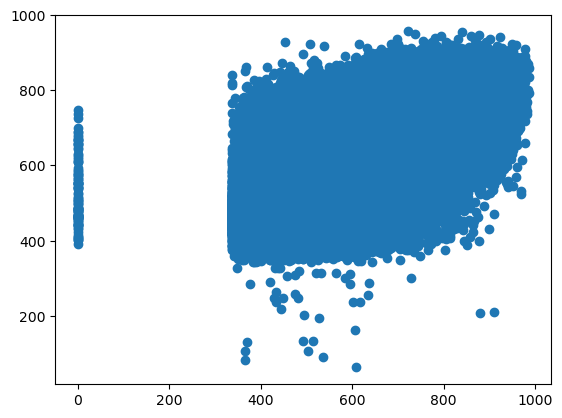

In [43]:
plt.scatter(target_test, predicao_RFR)
plt